# Разработка системы распознавания предметов интерьера в потоковом видео
## Часть 4: Нейронная сеть для сегментации 

In [1]:
class def_config:

    main_data_dir = "data/ADE20K_encoded/"
    callbacks_dir = "callbacks/"

    img_shape = 256
    classes_num = 17

    batch_size = 4
    epoch_num = 1
    train_coef = 0.001
    learning_rate = 0.0001

    last_activation = "sigmoid"
    loss_function = "categorical_crossentropy"

    gpu_memory_limit = 0.8
    cpu_threads_num = 4

    callbacks_monitor = "val_jaccard_coef"
    callbacks_data_format = "%m.%d_%H-%M"
    file_name = "DefName"
    
    is_load = False
    weight_path = None
    
    argparse_is_on = False
    
    
args = def_config()

In [2]:
# System
import os
import sys
import datetime
import time

# Base
import numpy as np
import cv2
import random

# Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout, BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, CSVLogger

# Preprocessing
from keras.utils import Sequence, to_categorical
from keras.utils.vis_utils import plot_model

# Backend
import tensorflow as tf
from keras import backend as K
from tensorflow.python.client import device_lib

# Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]="0" # first gpu

config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=args.cpu_threads_num,
                        inter_op_parallelism_threads=args.cpu_threads_num)
config.gpu_options.per_process_gpu_memory_fraction = args.gpu_memory_limit
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

# GPU check list
GPU_list = [x for x in device_lib.list_local_devices() 
            if x.device_type == 'GPU' or x.device_type == "GPU"]
print(GPU_list)

if not tf.test.is_gpu_available():
    raise OSError("GPU not found")

[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3389050060
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18255032546043522537
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


### 1. Настройки сегментации

Определим папки с изображениями и масками для обучения и валидации

In [4]:
main_data_dir = args.main_data_dir

train_dir = main_data_dir + "train/"
val_dir = main_data_dir + "val/"

img_train_dir = train_dir + "img/"
mask_train_dir = train_dir + "mask/"

img_val_dir = val_dir + "img/"
mask_val_dir = val_dir + "mask/"

# Callbacks

if def_config.argparse_is_on:
    file_name = sys.argv[0].split(".")[-2]
else:
    file_name = def_config.file_name
callbacks_dir = args.callbacks_dir

try:
    os.mkdir(callbacks_dir)
except OSError:
    pass

now = datetime.datetime.now()
callbacks_dir_name = file_name + now.strftime("_" + def_config.callbacks_data_format) + "/"

callbacks_full_dir = callbacks_dir + callbacks_dir_name
try:
    os.mkdir(callbacks_full_dir)
except OSError:
    pass

Размер обучающей и валидационной выборки

In [5]:
train_size = len(os.listdir(path=train_dir + "img/"))
val_size = len(os.listdir(path=val_dir + "img/"))
print("Train size: " + str(train_size))
print("Val size: " + str(val_size))

Train size: 6322
Val size: 623


Настроки нейронной сети

In [6]:
img_shape = args.img_shape
batch_size = args.batch_size
classes_num = args.classes_num

epoch_num = args.epoch_num
train_coef = args.train_coef
learning_rate = args.learning_rate

loss_function = args.loss_function
last_activation = args.last_activation

is_load = args.is_load
if is_load:
    weight_path = args.weight_path
else:
    weight_path = None


with open(callbacks_dir + callbacks_dir_name + "/" + "config.txt", "w") as f:
    if def_config.argparse_is_on:
        args_str = str(args).lstrip("Namespace(").rstrip(')')
        args_arr = args_str.split(", ")
        f.write("\n".join(args_arr))
    else:
        f.write("Def_config\n")

callbacks_monitor = args.callbacks_monitor

### 2. Метрики

Коэффициент Дайса

In [7]:
def dice_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((2. * intersection + smooth) / 
            (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

Коэффициент Джакарда

In [8]:
def jaccard_coef(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / 
            (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

### 3. Loss-функции 

In [9]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred)

### 3. Генератор данных

In [10]:
def data_gen(img_dir, mask_dir, classes_num, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir

    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)

    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0]  # отделяем имя от формата

    counter = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, classes_num)).astype("uint8")

        for i in range(counter, counter + batch_size):
            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img = cv2.resize(train_img, (img_shape, img_shape))

            img[i - counter] = train_img

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation=cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=classes_num)

            mask[i - counter] = train_mask

        counter += batch_size

        if counter + batch_size >= img_dir_size:
            counter = 0
            random.shuffle(img_list)

        yield img, mask


train_gen = data_gen(img_train_dir, mask_train_dir, classes_num=classes_num, batch_size=batch_size)
val_gen = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)


### 4. Модель

In [14]:
def conv_block(filters, layers, input_layer):
    output_layer = input_layer
    
    for i in range(layers):
        output_layer = Conv2D(filters, (3, 3), padding="same")(output_layer)
        #output_layer = BatchNormalization()(output_layer)
        output_layer = Activation("relu")(output_layer)
        
    #output_layer = Dropout(0.1)(output_layer)
    return output_layer


def get_model(img_shape, classes_num, last_activation, layers_in_block):
    block0_input = Input(shape=(img_shape, img_shape, 3))
    
    block1_conv = conv_block(64, layers_in_block, block0_input)
    block1_pool = MaxPool2D(2)(block1_conv)

    block2_conv = conv_block(128, layers_in_block, block1_pool)
    block2_pool = MaxPool2D(2)(block2_conv)

    block3_conv = conv_block(256, layers_in_block, block2_pool)
    block3_pool = MaxPool2D(2)(block3_conv)
    
    block4_conv = conv_block(512, layers_in_block, block3_pool)
    block4_pool = MaxPool2D(2)(block4_conv)
    
    block5_conv = conv_block(1024, layers_in_block, block4_pool)
    block5_upsa = MaxPool2D(2)(block5_conv)

    block6_conv = conv_block(2048, layers_in_block, block5_upsa)
    block6_upsa = UpSampling2D(2, interpolation="bilinear")(block6_conv)
    
    block7_conc = Concatenate()([block5_conv, block6_upsa])    

    block7_conv = conv_block(1024, layers_in_block, block7_conc)
    block7_upsa = UpSampling2D(2, interpolation="bilinear")(block7_conv)
    
    block8_conc = Concatenate()([block4_conv, block7_upsa])    

    block8_conv = conv_block(512, layers_in_block, block8_conc)
    block8_upsa = UpSampling2D(2, interpolation="bilinear")(block8_conv)
    
    block9_conc = Concatenate()([block3_conv, block8_upsa])
    
    block9_conv = conv_block(256, layers_in_block, block9_conc)
    block9_upsa = UpSampling2D(2, interpolation="bilinear")(block9_conv)

    block10_conc = Concatenate()([block2_conv, block9_upsa])
    
    block10_conv = conv_block(128, layers_in_block, block10_conc)
    block10_upsa = UpSampling2D(2, interpolation="bilinear")(block10_conv)

    block11_conc = Concatenate()([block1_conv, block10_upsa])
    
    block11_conv = conv_block(64, layers_in_block, block11_conc)

    block12_output = Conv2D(classes_num, (1, 1), padding="same", activation=last_activation)(block11_conv)

    return Model(inputs=block0_input, outputs=block12_output)

def one_block_model(img_shape, filters, layers_in_block):
    block_input = Input(shape=(img_shape, img_shape, 3))
    block_output = conv_block(filters, layers_in_block, block_input)
    block_hide = Conv2D(filters, (3, 3), padding="same")(block_output)
    return Model(inputs=block_input, outputs=block_hide)

In [19]:
block_model = one_block_model(args.img_shape, 64,  1)
model = get_model(args.img_shape, args.classes_num, args.last_activation, 1)

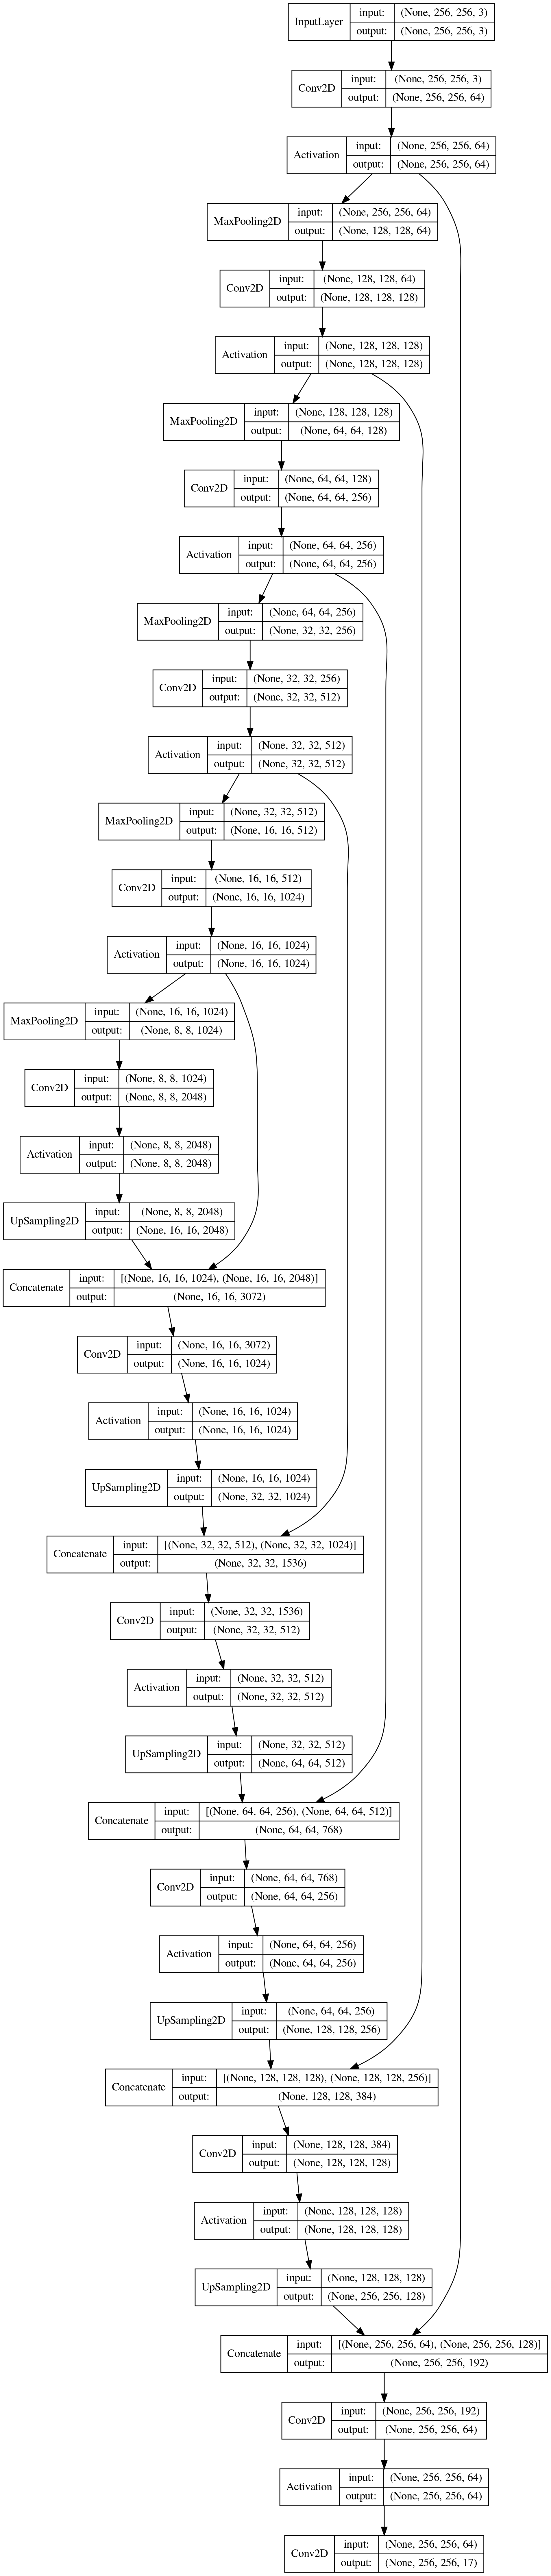

In [20]:
plot_model(model=model, to_file=callbacks_full_dir + file_name + ".png", 
           show_shapes=True, show_layer_names=False, dpi=200)

### 5. Callbacks

In [14]:
def get_callbacks(dir_path, callbacks_monitor):
    # лучшие веса
    best_w_loss = ModelCheckpoint(dir_path + "best_w_loss.h5",
                             monitor="val_loss",
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                             )
    
    best_w_jaccard = ModelCheckpoint(dir_path + "best_w_jaccard.h5",
                             monitor="val_jaccard_coef",
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                             )

    # последние веса
    last_w = ModelCheckpoint(dir_path + "last_w.h5",
                             verbose=0,
                             save_best_only=False,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                             )

    # сохраняет историю обучения
    logger = CSVLogger(dir_path + "logger.csv",
                       append=False)

    return [best_w_loss, best_w_jaccard, last_w, logger]

In [15]:
if last_activation != 'sigmoid' and last_activation != 'softmax':
    raise ValueError("Incorrect last activation :" + last_activation)

model = get_model(None, classes_num, last_activation, layers_in_block=3)

plot_model(model=model, to_file=callbacks_full_dir + file_name + ".png", 
           show_shapes=True, show_layer_names=False, dpi=200)

if is_load:
    if not weight_path:
        raise ValueError("Don't load weight_path")
    model.load_weights(weight_path)

if loss_function == 'categorical_crossentropy':
    pass
elif loss_function == 'dice_loss':
    loss_function = dice_loss
elif loss_function == 'jaccard_loss':
    loss_function = jaccard_loss
else:
    raise ValueError("Incorrect loss function :" + loss_function)

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss=loss_function,
              metrics=["accuracy", dice_coef, jaccard_coef])

In [16]:
model.fit_generator(train_gen,
                    epochs=epoch_num,
                    steps_per_epoch=int(train_coef * train_size) // batch_size,
                    validation_data=val_gen,
                    validation_steps=val_size // batch_size,
                    verbose=1,
                    callbacks=get_callbacks(callbacks_full_dir, callbacks_monitor)
                    )

Epoch 1/1
1/1 [==============================] - 22s 22s/step - loss: 2.9348 - accuracy: 0.0359 - dice_coef: 0.1044 - jaccard_coef: 0.0551 - val_loss: 2.8339 - val_accuracy: 0.0106 - val_dice_coef: 0.1051 - val_jaccard_coef: 0.0555


In [15]:
start_time = time.time()

val_gen_test = data_gen(img_val_dir, mask_val_dir, classes_num=classes_num, batch_size=batch_size)

for (img, mask), i in zip(val_gen_test, range(val_size // batch_size)):
    model.predict(img)
    
stop_time = time.time()

sec_on_one_img = (stop_time - start_time)/val_size
with open(callbacks_full_dir + "time.txt", "w") as f:
    f.write(str(sec_on_one_img))

(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 256, 31)
(4, 256, 2